In [8]:
%matplotlib inline

# Section 3: Machine learning to predict age from rs-fmri

We will integrate what we've learned in the previous sections to extract data from rs-fmri images, and use that data as features in a machine learning model

The dataset consists of ~150 subjects, mostly young children and some young adults. We will use rs-fmri data to predict the age of the participants

#### Run the cell below to ready the download script (otherwise ignore it).

In [1]:
import warnings

import numpy as np

from sklearn.datasets.base import Bunch
from nilearn.datasets.utils import _get_dataset_dir, _fetch_files


def fetch_data(n_subjects=30, data_dir=None, url=None, resume=True,
               verbose=1):
    """Download and load the dataset.

    Parameters
    ----------
    n_subjects: int, optional
        The number of subjects to load from maximum of 40 subjects.
        By default, 30 subjects will be loaded. If None is given,
        all 40 subjects will be loaded.

    data_dir: string, optional
        Path of the data directory. Used to force data storage in a specified
        location. Default: None

    url: string, optional
        Override download URL. Used for test only (or if you setup a mirror of
        the data). Default: None

    Returns
    -------
    data: sklearn.datasets.base.Bunch
        Dictionary-like object, the interest attributes are :
         - 'func': Paths to functional resting-state images
         - 'phenotypic': Explanations of preprocessing steps
         - 'confounds': CSV files containing the nuisance variables

    References
    ----------
    :Download:
        https://openneuro.org/datasets/ds000228/versions/00001

    """

    if url is None:
        url = 'https://openneuro.org/crn/datasets/ds000228/snapshots/00001/files/'

    # Preliminary checks and declarations
    dataset_name = 'ds000228'
    data_dir = _get_dataset_dir(dataset_name, data_dir=data_dir,
                                verbose=verbose)
    max_subjects = 155
    if n_subjects is None:
        n_subjects = max_subjects
    if n_subjects > max_subjects:
        warnings.warn('Warning: there are only %d subjects' % max_subjects)
        n_subjects = max_subjects
    ids = range(1, n_subjects + 1)

    # First, get the metadata
    phenotypic = (
            'participants.tsv',
            url + 'participants.tsv', dict())

    phenotypic = _fetch_files(data_dir, [phenotypic], resume=resume,
                              verbose=verbose)[0]

    # Load the csv file
    phenotypic = np.genfromtxt(phenotypic, names=True, delimiter='\t',
                               dtype=None)

    # Keep phenotypic information for selected subjects
    int_ids = np.asarray(ids, dtype=int)
    phenotypic = phenotypic[[i - 1 for i in int_ids]]

    # Download dataset files

    functionals = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_swrf_bold.nii.gz' % (i, i)
        for i in ids]
    urls = [url + name for name in functionals]
    functionals = _fetch_files(
        data_dir, zip(functionals, urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    confounds = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_ART_and_CompCor_nuisance_regressors.mat'
        % (i, i)
        for i in ids]
    confound_urls = [url + name for name in confounds]

    confounds = _fetch_files(
        data_dir, zip(confounds, confound_urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    return Bunch(func=functionals, confounds=confounds,
                 phenotypic=phenotypic, description='ds000228')


In [2]:
# Confounds function

import h5py
import numpy as np

def prepare_confounds(conf, key = 'R', transpose=True):
    arrays = {}
    f = h5py.File(conf)
    for k, v in f.items():
        arrays[k] = np.array(v)
    
    if transpose:
        output = arrays[key].T
    else:
        output = arrays[key]
    
    return output

### Load the data

If you already have downloaded the data, the next commands should load it. If you have not, the data will begin downloading. This is a lot of data (more than 14 GB) so maybe not good to download right now!

You can still pop in after the "extract features" section

In [3]:
# if the data is already stored somewhere OR you want to store it somewhere, specify this here
#wdir = '/Users/jakevogel/Science/Nilearn_tutorial/ds000028/'
wdir = '/data1/users/jvogel/Nilearn_tutorial/'
#wdir = None

In [4]:
# Now fetch the data
data = fetch_data(None,data_dir=wdir)

How many individual subjects do we have?

In [5]:
len(data.func)

155

### Get Y (our target) and assess its distribution

In [6]:
# Let's load the phenotype data
data.phenotypic

array([ (b'sub-pixar001',   4.77481177, b'4yo', b'child', b'M', b'R', b'0.8', b'0.736842105', b'6', b'pass', b'22', b'13', b'n/a', b'n/a', b'3', b'3T1', b'7-8yo 32ch', b'3mm iso', b'0.1'),
       (b'sub-pixar002',   4.8569473 , b'4yo', b'child', b'F', b'R', b'0.72', b'0.736842105', b'4', b'inc', b'18', b'9', b'n/a', b'n/a', b'2', b'3T1', b'7-8yo 32ch', b'3mm iso', b'0.1'),
       (b'sub-pixar003',   4.15331964, b'4yo', b'child', b'F', b'R', b'0.44', b'0.421052632', b'3', b'inc', b'15', b'9', b'n/a', b'n/a', b'3', b'3T1', b'7-8yo 32ch', b'3mm iso', b'0.1'),
       (b'sub-pixar004',   4.47364819, b'4yo', b'child', b'F', b'R', b'0.64', b'0.736842105', b'2', b'fail', b'17', b'10', b'n/a', b'n/a', b'3', b'3T1', b'7-8yo 32ch', b'3mm iso', b'0.2'),
       (b'sub-pixar005',   4.83778234, b'4yo', b'child', b'F', b'R', b'0.6', b'0.578947368', b'4', b'inc', b'13', b'5', b'n/a', b'n/a', b'2', b'3T1', b'7-8yo 32ch', b'3mm iso', b'0.2'),
       (b'sub-pixar006',   3.60574949, b'3yo', b'child', b'F',

In [12]:
#from pandas import read_csv
from pandas import DataFrame

#pheno = read_csv(data.phenotypic)
#pheno = read_csv(data.phenotypic, sep='\t')
pheno = DataFrame(data.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM_BookletMatched,ToM_BookletMatchedNOFB,FB_Composite,FB_Group,WPPSI_BD_raw,WPPSI_BD_scaled,KBIT_raw,KBIT_standard,DCCS_Summary,Scanlog_Scanner,Scanlog_Coil,Scanlog_Voxel_slize,Scanlog_Slice_Gap
0,b'sub-pixar001',4.774812,b'4yo',b'child',b'M',b'R',b'0.8',b'0.736842105',b'6',b'pass',b'22',b'13',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
1,b'sub-pixar002',4.856947,b'4yo',b'child',b'F',b'R',b'0.72',b'0.736842105',b'4',b'inc',b'18',b'9',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
2,b'sub-pixar003',4.153320,b'4yo',b'child',b'F',b'R',b'0.44',b'0.421052632',b'3',b'inc',b'15',b'9',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
3,b'sub-pixar004',4.473648,b'4yo',b'child',b'F',b'R',b'0.64',b'0.736842105',b'2',b'fail',b'17',b'10',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'
4,b'sub-pixar005',4.837782,b'4yo',b'child',b'F',b'R',b'0.6',b'0.578947368',b'4',b'inc',b'13',b'5',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'


Looks like there is a column for age. Let's capture it in a variable

In [13]:
y_age = pheno['Age']
y_age.head()

0    4.774812
1    4.856947
2    4.153320
3    4.473648
4    4.837782
Name: Age, dtype: float64

Maybe we should have a look at the distribution of our target variable

(array([ 67.,  47.,   8.,   0.,  11.,   8.,   6.,   4.,   3.,   1.]),
 array([  3.51813826,   7.06632443,  10.61451061,  14.16269678,
         17.71088296,  21.25906913,  24.8072553 ,  28.35544148,
         31.90362765,  35.45181383,  39.        ]),
 <a list of 10 Patch objects>)

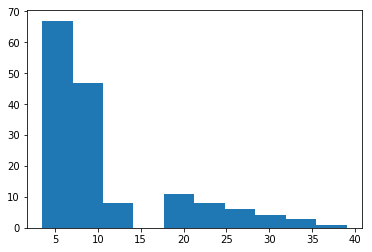

In [14]:
import matplotlib.pyplot as plt
plt.hist(y_age)

Seems pretty skewed toward younger children. Perhaps we will have better results by log-transforming age?

(array([ 26.,  30.,  17.,  27.,  20.,   2.,   2.,  17.,   8.,   6.]),
 array([ 1.25793195,  1.49849492,  1.73905789,  1.97962086,  2.22018383,
         2.4607468 ,  2.70130977,  2.94187274,  3.18243571,  3.42299868,
         3.66356165]),
 <a list of 10 Patch objects>)

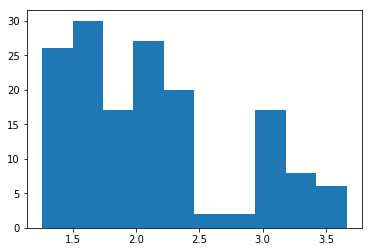

In [15]:
log_y_age = np.log(y_age)
plt.hist(log_y_age)


That's a bit better. Maybe we will want to use log-transformed age in our models?

### Extract features

Here, we are going to use the same techniques we learned in section 2 to extract rs-fmri connectivity features from every subject.

How are we going to do that? With a for loop.

Don't worry, it's not as scary as it sounds

In [16]:
# Here is a really simple for loop

for i in range(10):
    print('the number is', i)

the number is 0
the number is 1
the number is 2
the number is 3
the number is 4
the number is 5
the number is 6
the number is 7
the number is 8
the number is 9


In [17]:
container = []
for i in range(10):
    container.append(i)

container

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Now lets construct a more complicated loop to do what we want

First we do some things we don't need to do in the loop. Let's reload our atlas, and re-iniate our masker and correlation_measure

In [18]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

In [19]:
vectorized = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
not_vectorized = ConnectivityMeasure(kind='correlation', vectorize=False)

In [20]:
# example
sub = data.func[0]
conf = prepare_confounds(data.confounds[0])
time_series = masker.fit_transform(sub, confounds=conf)
v_corr = vectorized.fit_transform([time_series])[0]
nv_corr = not_vectorized.fit_transform([time_series])[0]

print('vectorized:', v_corr.shape)
print('not vectorized:', nv_corr.shape)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:118: UserWarning: Incompatible cache in nilearn_cache/joblib: different version of nibabel. Deleting the cache. Put nilearn.CHECK_CACHE_VERSION to false to avoid this behavior.
  % cachedir)


vectorized: (2016,)
not vectorized: (64, 64)


In [ ]:
# nfeat = 
# nfeat * (nfeat-1) / 2

Okay -- now that we have that cleared up, let's run our big loop!

**NOTE**: On a laptop, this might take quite a long time. It took 30 minutes on my mac. 

**Maybe don't run it right now!**

In [42]:
# all_features = [] # here is where we will put the data (a container)

# for i,sub in enumerate(data.func):
#     # convert confounds to readable format
#     conf = prepare_confounds(data.confounds[i])
#     # extract the timeseries from the ROIs in the atlas
#     time_series = masker.fit_transform(sub, confounds=conf)
#     # create a region x region correlation matrix
#     correlation_matrix = correlation_measure.fit_transform([time_series])[0]
#     # add to our container
#     all_features.append(correlation_matrix)
#     # keep track of status
#     print('finished %s of %s'%(i+1,len(data.func)))

finished 1 of 155


KeyboardInterrupt: 

In [ ]:
# Let's save the data to disk

# np.savez_compressed('BASC064_features',a = all_features, b = full_y)

In case you do not want to run the full loop on your computer, you can load the output of the loop here!

In [21]:
feat_file = 'BASC064_features.npz'
X_features = np.load(feat_file)['a']

In [22]:
X_features.shape

(155, 2016)

Okay so we've got our features.

We can visualize our feature matrix

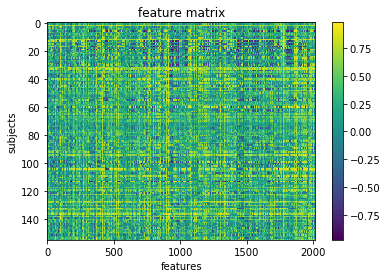

In [23]:
plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

### Prepare data for machine learning

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "test" sample that we will not touch until the end

We want to be sure that our training and test sample are matched! We can do that with a "stratified split". Specifically, we will stratify by age group.

In [24]:
age_groups = pheno['AgeGroup']

In [25]:
from sklearn.model_selection import train_test_split

# Split the sample to training/test with a 60/40 ratio, and 
# stratify by age group, and also shuffle the data.

X_train, X_test, y_train, y_test, ageGroup_train, ageGroup_test = train_test_split(
                                                                X_features, 
                                                                y_age, 
                                                                age_groups,
                                                                test_size = 0.4, 
                                                                shuffle = True,
                                                                stratify = age_groups,
                                                                random_state = 123
                                                                                   )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_test))

training: 93 testing: 62


Let's visualize the distributions to be sure they are matched

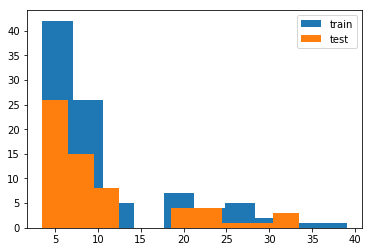

In [26]:
plt.hist(y_train, label = 'train')
plt.hist(y_test, label = 'test')
plt.legend()

### Run your first model!

Machine learning can get pretty fancy pretty quickly. We'll start with a very standard linear model called a Support Vector Regressor (SVR). 

While this may seem unambitious, simple models can be very robust. And we don't have enough data to create more complex models.

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

Let's fit our first model!

In [27]:
from sklearn.svm import SVR

l_svr = SVR(kernel='linear') # define the model

l_svr.fit(X_train, y_train) # fit the model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Well... that was easy. Let's see how well the model learned the data!

We will judge our model on two criteria:
* R2 = r-sqaure: the variance of the test data explained by the model
* mae = mean absolute error: how off our measurements are in absolute units (years!)

In [28]:
from sklearn.metrics import mean_absolute_error

y_pred = l_svr.predict(X_train) # predict the training data based on the model
r2 = l_svr.score(X_train, y_train) # get the r2
mae = mean_absolute_error(y_true = y_train, 
                          y_pred = y_pred) # get the mae

Let's view our results and plot them all at once!

r2 = 0.999845931201, mae = 0.0998295500472


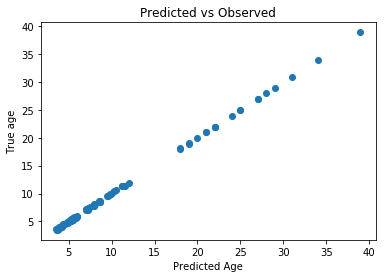

In [29]:
print('r2 = %s, mae = %s'%(r2,mae))

plt.scatter(y_train, y_pred)
plt.title('Predicted vs Observed')
plt.xlabel('Predicted Age')
plt.ylabel('True age')

HOLY COW! Machine learning is amazing!!! Almost a perfect fit!

...which means there's something wrong. What's the problem here?

In [30]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# predict
y_pred = cross_val_predict(l_svr, X_train, y_train, 
                           groups=ageGroup_train, cv=10)
# scores
r2 = cross_val_score(l_svr, X_train, y_train, 
                     groups=ageGroup_train, cv=10)
mae_score = cross_val_score(l_svr, X_train, y_train, 
                            groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

We can look at the accuracy of the predictions for each fold of the cross-validation

In [31]:
print(r2)

[-2.80638341  0.7303517   0.78370326  0.64741573  0.50406747  0.73287536
  0.66216006  0.47937879 -5.74156208  0.60543526]


We can also look at the overall accuracy of the model

r2 = 0.616206422436, mae = 3.85640633193


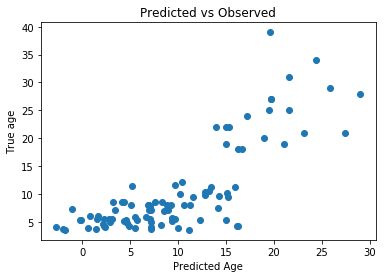

In [32]:
from sklearn.metrics import r2_score

overall_r2 = r2_score(y_pred = y_pred, y_true = y_train)
overall_mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('r2 = %s, mae = %s'%(overall_r2,overall_mae))

plt.scatter(y_pred, y_train)
plt.title('Predicted vs Observed')
plt.xlabel('Predicted Age')
plt.ylabel('True age')

Not too bad at all! But what are some things you notice about our results?

### Tweak your model

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's find to try different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

We could try other models, or tweak hyperparameters, but we are probably not powered sufficiently to do so, and would once again risk overfitting.


But we can perhaps look at the performance of the model on log-transformed data

In [33]:
log_y_train = np.log(y_train) # log-transform target data

r2 = 0.606790089275, mae = 0.317176735718


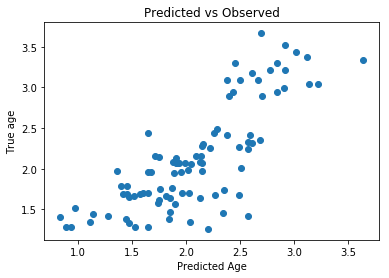

In [34]:
# repeat the steps above to re-fit the model 
# and assess its performance

# don't forget to switch y_train to log_y_train
y_pred = cross_val_predict(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10)
r2 = cross_val_score(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10)
mae_score = cross_val_score(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

# don't forget to switch y_train to log_y_train
overall_r2 = r2_score(y_pred = y_pred, y_true = log_y_train)
overall_mae = mean_absolute_error(y_pred = y_pred, y_true = log_y_train)
print('r2 = %s, mae = %s'%(overall_r2,overall_mae))

plt.scatter(y_pred, log_y_train)
plt.title('Predicted vs Observed')
plt.xlabel('Predicted Age')
plt.ylabel('True age')

What do you think about the results of this model compared to the non-transformed model?

**Exercise:** Try fitting a new SVR model and tweak one of the many parameters. Run cross-validation and see how well it goes. Make a new cell and type SVR? to see the possible hyperparameters

In [ ]:
# new_model = SVR() 

### Can our model predict age in completely un-seen data?
Now that we've fit a model we think has possibly learned how to decode age based on rs-fmri signal, let's put it to the test. We will train our model on all of the training data, and try to predict the age of the subjects we left out at the beginning of this section.

Because we performed a transformation on our training data, we will need to transform our testing data using the *same information!* 

For that, we will need to create a transformer

In [35]:
# transform testing set based on training distribution...
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log).fit(y_train.values.reshape(-1,1))
log_y_test = transformer.transform(y_test.values.reshape(-1,1))[:,0]

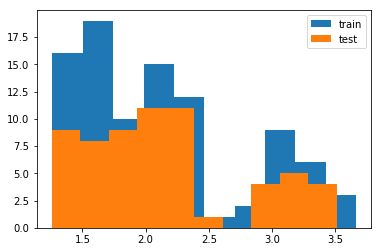

In [36]:
# how did we do?
plt.hist(log_y_train, label = 'train')
plt.hist(log_y_test, label = 'test')
plt.legend()

And now for the moment of truth! 

No cross-validation needed here. We simply fit the model with the training data and use it to predict the testing data

I'm so nervous. Let's just do it all in one cell

r2 = 0.564505226695, mae = 0.357199538738


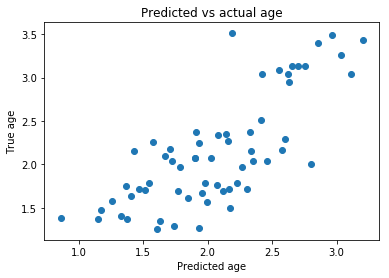

In [37]:
l_svr.fit(X_train, log_y_train) # fit to training data
y_pred = l_svr.predict(X_test) # predict age using testing data
r2 = l_svr.score(X_test, log_y_test) # get r2 score
mae = mean_absolute_error(y_pred=y_pred, y_true=log_y_test) # get mae

# print results
print('r2 = %s, mae = %s'%(r2,mae))

# plot results
plt.scatter(y_pred, log_y_test)
plt.title('Predicted vs actual age')
plt.xlabel('Predicted age')
plt.ylabel('True age')

***Wow!!*** Congratulations. You just trained a machine learning model that used real rs-fmri data to predict the age of real humans.

It seems like something in this data does seem to be systematically related to age ... but what?  

### Interpreting model feature importances
Interpreting the feature importances of a machine learning model is a real can of worms. This is an area of active research. Unfortunately, it's hard to trust the feature importance of some models. 

You can find a whole tutorial on this subject here:
http://gael-varoquaux.info/interpreting_ml_tuto/index.html

For now, we'll just eschew better judgement and take a look at our feature importances

We can access the feature importances (weights) used my the model

In [38]:
l_svr.coef_

array([[-0.00784157, -0.0063221 ,  0.00710295, ...,  0.01095685,
        -0.01118909,  0.00592823]])

lets plot these weights to see their distribution better

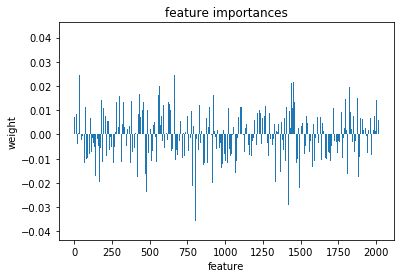

In [39]:
plt.bar(range(l_svr.coef_.shape[-1]),l_svr.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

Or perhaps it will be easier to visualize this information as a matrix similar to the one we started with

We can use the correlation measure from before to perform an inverse transform

In [43]:
correlation_measure.inverse_transform(l_svr.coef_).shape

(1, 64, 64)

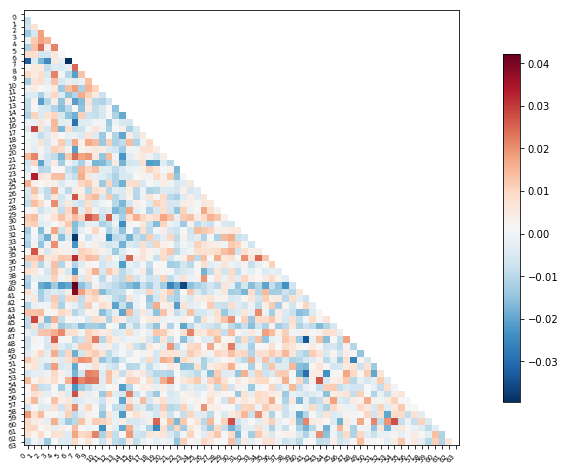

In [44]:
from nilearn import plotting

feat_exp_matrix = correlation_measure.inverse_transform(l_svr.coef_)[0]

plotting.plot_matrix(feat_exp_matrix, figure=(10, 8), 
                     labels=range(feat_exp_matrix.shape[0]),
                     reorder=False,
                    tri='lower')

Let's see if we can throw those features onto an actual brain.

First, we'll need to gather the coordinates of each ROI of our atlas

In [ ]:
# from nibabel import Nifti1Image

# def lazy_get_coords(atlas_filename):
#     coords = []
#     img = image.load_img(atlas_filename)
#     atlas_data = img.get_data()
#     aff = img.affine
#     values = np.unique(atlas_data)[1:]
#     for i in values:
#         roi = np.zeros_like(atlas_data)
#         roi[atlas_data==i] = 1.0
#         coords.append(plotting.find_xyz_cut_coords(Nifti1Image(roi,aff)))
    
#     return coords

In [ ]:
# atlas_coordinates = lazy_get_coords(atlas_filename)
# np.savez_compressed(os.path.join(outdir,'BASC064_coordinates'),
#                    a = atlas_coordinates)

In [45]:
coords = np.load('BASC064_coordinates.npz')['a']

And now we can use our feature matrix and the wonders of nilearn to create a connectome map where each node is an ROI, and each connection is weighted by the importance of the feature to the model

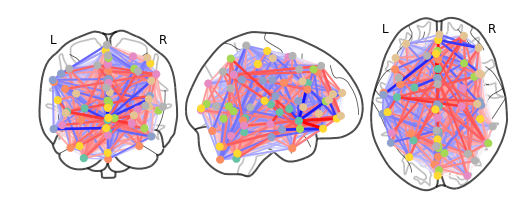

In [46]:
plotting.plot_connectome(feat_exp_matrix, coords)

# Appendix: Goodies and extra points

**Exercise:** There are is a clear distinction between adults in children in this dataset. See if you can train a classifier (for example, SVC) to predict which subjects are adults and which are children. 

Return your overall accuracy, but also the positive predictive value (precisions score). You can tweak your model, but remember, don't burn your test data or your results don't count! Also remember you don't have many subjects to work with in the first place. 

For a bonus, plot the feature importances, and correlate the feature importances with those from our linear model predicting age

In [ ]:
# from sklearn.svm import SVC
# y_class_train = [1 if x==b'Adult' else 0 for x in ageGroup_train]
# y_class_test = [1 if x==b'Adult' else 0 for x in ageGroup_test]